Download FER-2013 from Kaggle

In [51]:
!pip install kaggle


In [52]:
!pip install mediapipe
!pip install tensorflow


In [53]:
!pip install opencv-python
!pip install matplotlib
!pip install pandas
!pip install scikit-learn
!pip install scikit-image


In [54]:
import os
# Specify the directory to save the dataset
save_directory_data = os.path.expanduser('~/Downloads')
os.makedirs(save_directory_data, exist_ok=True)
# Download the dataset
os.system(f'kaggle datasets download -d msambare/fer2013 -p "{save_directory_data}"')
!pip install xgboost


Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
fer2013.zip: Skipping, found more recently modified local copy (use --force to force download)


In [55]:
import cv2
import matplotlib.pyplot as plt
import random
from collections import Counter
import numpy as np
import pandas as pd
import random
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import shutil
from sklearn.preprocessing import LabelEncoder
from skimage import exposure
import os
import matplotlib.pyplot as plt
import mediapipe as mp
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVC
import cv2
from skimage.filters import gabor_kernel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import hog
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score, KFold, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from time import time, sleep
xPixel = 48  
yPixel = 48

In [56]:
# Directory paths
train_dir = os.path.expanduser('/fer2013_copy/train')
test_dir = os.path.expanduser('/fer2013_copy/test')

In [57]:
# Define a function to load data
def load_images_from_directory(directory):
    images = []
    labels = []
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):
            for file in os.listdir(label_path):
                file_path = os.path.join(label_path, file)
                image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                images.append(image)
                labels.append(label)
    return images, labels

# Load training and testing images
train_images, train_labels = load_images_from_directory(train_dir)
test_images, test_labels = load_images_from_directory(test_dir)

print(f"Loaded {len(train_images)} training images and {len(test_images)} testing images.")

Loaded 28709 training images and 7178 testing images.


In [58]:
# Define a function to count the number of images in each category
def count_images_per_category(labels, dataset_label):
    category_counts = Counter(labels)
    total_images = len(labels)
    
    # Print the counts for each category
    print(f"\n{dataset_label} set:")
    for category, count in category_counts.items():
        print(f"Category '{category}': {count} images")
    
    print(f"Total number of images in {dataset_label} set: {total_images}")
    return category_counts, total_images

# Count images in training and testing
train_counts, num_train_images = count_images_per_category(train_labels, "Training")
test_counts, num_test_images = count_images_per_category(test_labels, "Testing")


Training set:
Category 'happy': 7215 images
Category 'sad': 4830 images
Category 'fear': 4097 images
Category 'surprise': 3171 images
Category 'neutral': 4965 images
Category 'angry': 3995 images
Category 'disgust': 436 images
Total number of images in Training set: 28709

Testing set:
Category 'happy': 1774 images
Category 'sad': 1247 images
Category 'fear': 1024 images
Category 'surprise': 831 images
Category 'neutral': 1233 images
Category 'angry': 958 images
Category 'disgust': 111 images
Total number of images in Testing set: 7178


Visualzie Random Samples from Each Category

Label: happy


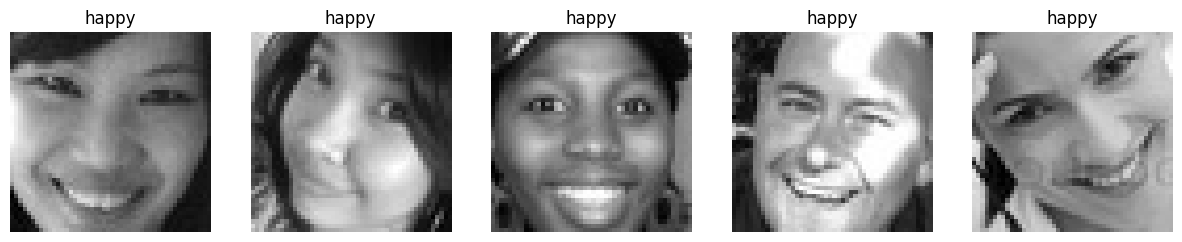

Label: angry


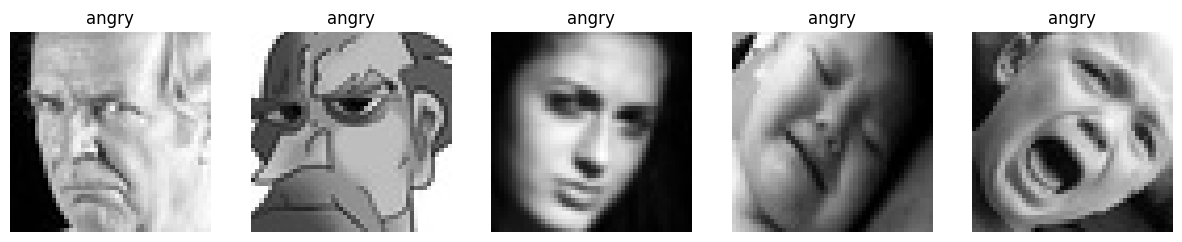

Label: neutral


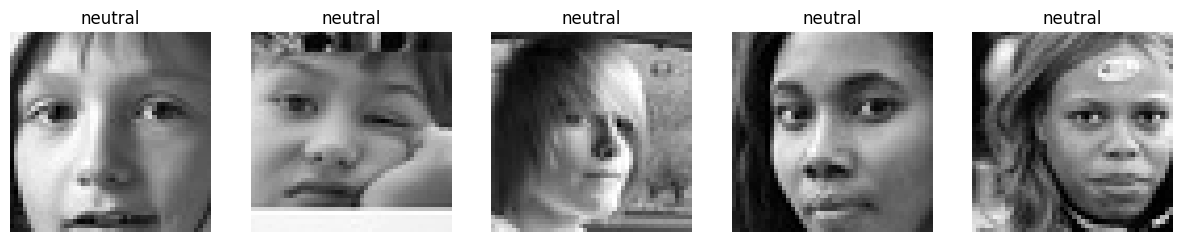

Label: fear


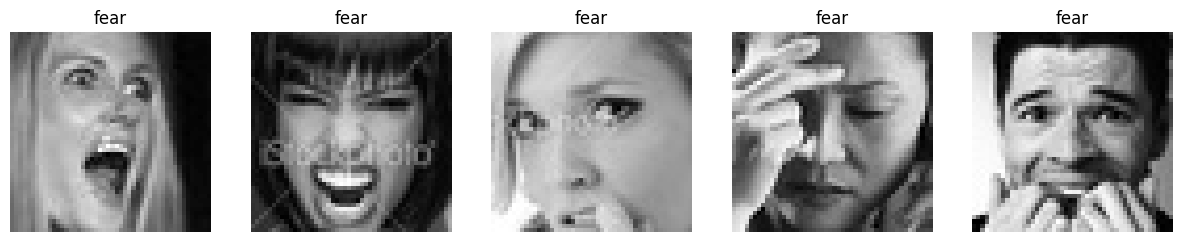

Label: disgust


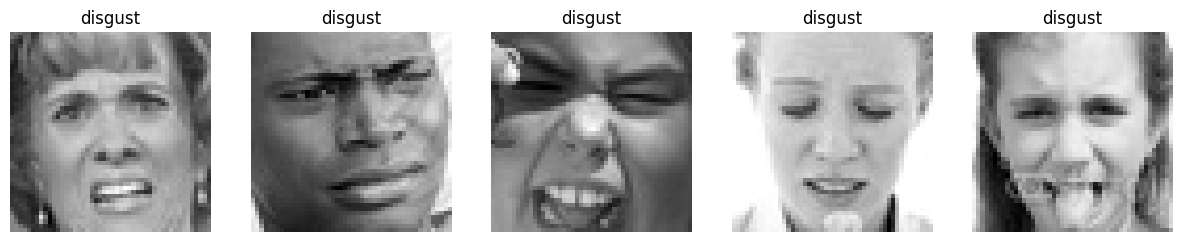

Label: sad


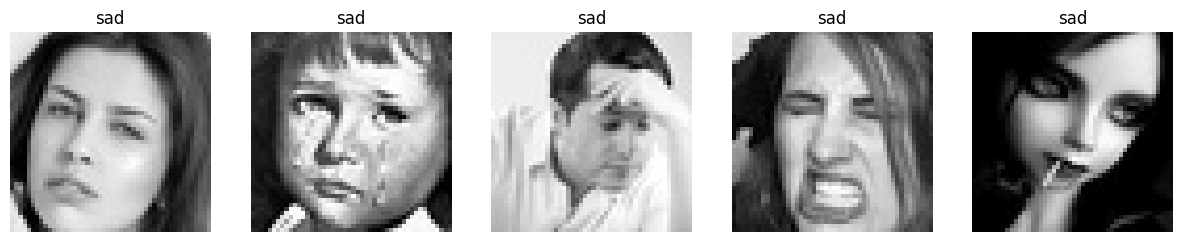

Label: surprise


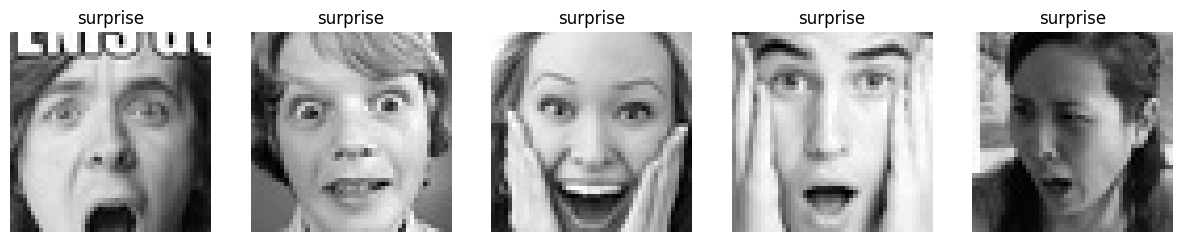

Label: happy


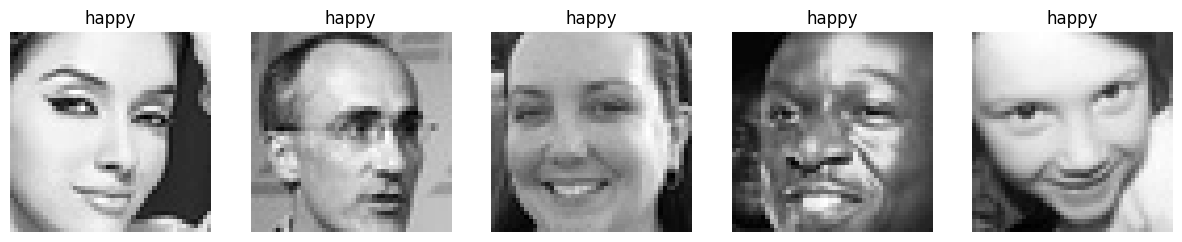

Label: angry


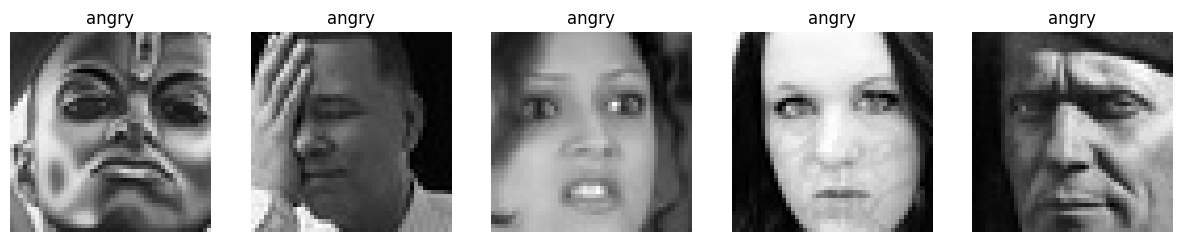

Label: neutral


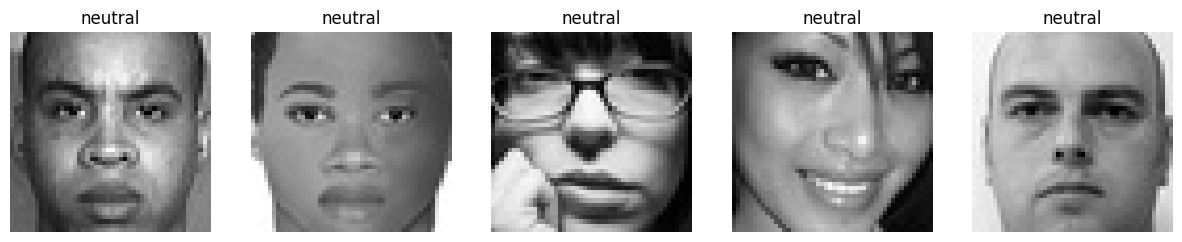

Label: fear


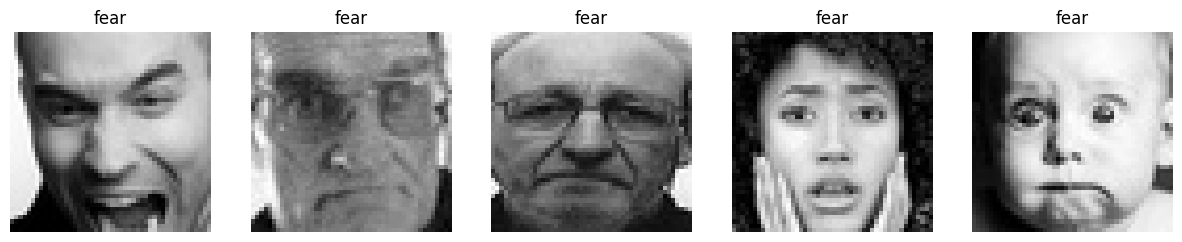

Label: disgust


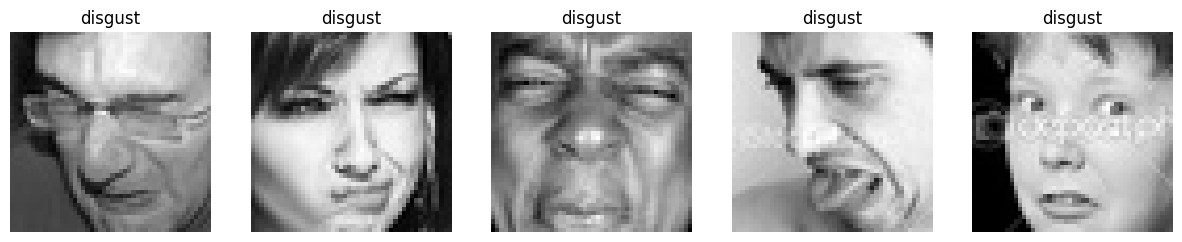

Label: sad


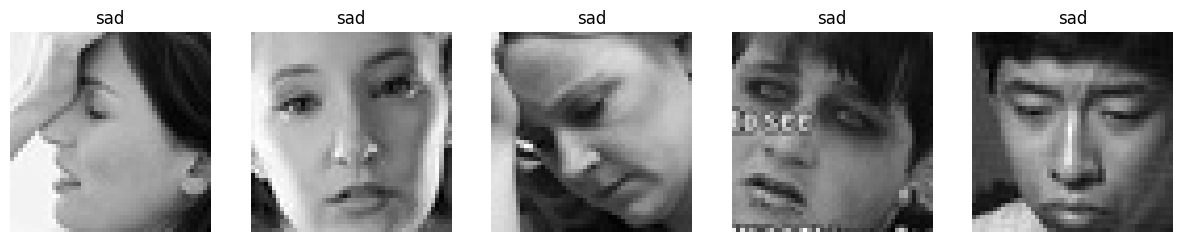

Label: surprise


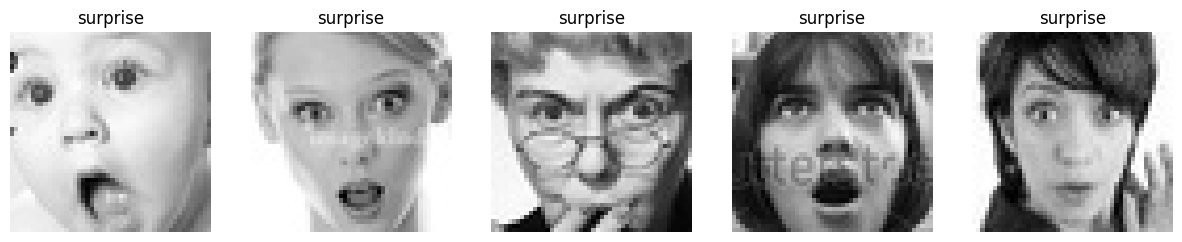

In [59]:
# Define a function to visualize random samples from each category
def visualize_samples(images, labels, num_samples=5, dataset_label="Dataset"):
    unique_labels = set(labels)
    
    for label in unique_labels:
        label_images = [img for img, lbl in zip(images, labels) if lbl == label]
        
        print(f"Label: {label}")
        sample_images = random.sample(label_images, min(num_samples, len(label_images)))
        
        plt.figure(figsize=(15, 3))
        for i, image in enumerate(sample_images):
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(image, cmap='gray')
            plt.title(label)
            plt.axis('off')
        
        plt.show()

# Visualize samples from training and testing
visualize_samples(train_images, train_labels, num_samples=5, dataset_label="Training")
visualize_samples(test_images, test_labels, num_samples=5, dataset_label="Testing")

Data Cleaning

In [60]:
# Define a function to check if images are loaded correctly and correct size
def check_images(images, labels, dataset_label="Dataset"):
    invalid_images = []
    for i, image in enumerate(images):
        if image is None or image.shape != (48, 48):
            print(f"Invalid image detected in {dataset_label} set: Label - {labels[i]}, Index - {i}")
            invalid_images.append((labels[i], i))  # Store label and index of invalid images
    print(f"Total invalid images in {dataset_label} set: {len(invalid_images)}")

# Check the training and testing sets in memory
check_images(train_images, train_labels, dataset_label="Training")
check_images(test_images, test_labels, dataset_label="Testing")

Total invalid images in Training set: 0
Total invalid images in Testing set: 0


Addressing Data Imbalance: Step 1 Downsample 'happy' to 5000 Images

Addressing Data Imbalance: Step 2 Augmentation

Count the Number of Images in Each Category

In [61]:
# Load training balanced dataset
train_images, train_labels = load_images_from_directory(train_dir)
test_images, test_labels = load_images_from_directory(test_dir)
# Count images in training balanced dataset
train_counts, num_train_images = count_images_per_category(train_labels, "Training")


Training set:
Category 'happy': 7215 images
Category 'sad': 4830 images
Category 'fear': 4097 images
Category 'surprise': 3171 images
Category 'neutral': 4965 images
Category 'angry': 3995 images
Category 'disgust': 436 images
Total number of images in Training set: 28709


Feature Extraction for Training Balanced Dataset

In [62]:

mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True)  


def extract_mediapipe_features(image, label_images):
 
    """
    Extract facial landmarks using MediaPipe Face Mesh. If no face is detected,
    continually retry with a randomly selected and augmented image from the same label.
    
    Parameters:
    - image: The initial input image to extract features from.
    - label_images: List of images under the same label to select from if retry is needed.
    
    Returns:
    - feature_vector: List of landmark (x, y, z) coordinates.
    """

    while True:
        # Ensure image is of type uint8 (0-255 range)
        image_uint8 = np.array(image, dtype=np.uint8)
        
        # Convert to RGB if grayscale
        if len(image_uint8.shape) == 2:  # Grayscale image
            image_rgb = cv2.cvtColor(image_uint8, cv2.COLOR_GRAY2RGB)
        else:
            image_rgb = image_uint8
        
        # Verify and re-cast to ensure MediaPipe compatibility
        image_rgb = np.array(image_rgb, dtype=np.uint8)
        #print("Image shape after conversion:", image_rgb.shape, "Data type:", image_rgb.dtype)
        
        # Process with MediaPipe Face Mesh
        results = face_mesh.process(image_rgb)
        
        if results.multi_face_landmarks:
            # Extract landmark coordinates for the detected face
            feature_vector = []
            for landmark in results.multi_face_landmarks[0].landmark:
                x, y, z = landmark.x, landmark.y, landmark.z
                #flattened 1d features
                feature_vector.extend([x, y, z]) 
                #feature_vector.append([x, y, z])
            return feature_vector  # Return feature vector if landmarks are detected
        
        # If no face is detected, print message and retry with augmented image
        print("No face detected in the image. Retrying with augmented image...")
        image = random.choice(label_images)  # Randomly choose a new image from the same label


# Process each category separately
train_features = []
test_features = []
for label in set(train_labels):  # Iterate over each unique label
    # Filter images and labels for the current label
    label_images = [img for img, lbl in zip(train_images, train_labels) if lbl == label]
    
    # Process each image in the current label category
    for i, image in enumerate(label_images):
        #print(f"Processing image {i+1}/{len(label_images)} for label '{label}'")
        feature_vector = extract_mediapipe_features(image, label_images)  # Pass both image and label_images
        if feature_vector is not None:
            train_features.append(feature_vector)

print("Feature extraction completed.")

for label in set(test_labels):  # Iterate over each unique label
    # Filter images and labels for the current label
    label_images = [img for img, lbl in zip(test_images, test_labels) if lbl == label]
    
    # Process each image in the current label category
    for i, image in enumerate(label_images):
        #print(f"Processing image {i+1}/{len(label_images)} for label '{label}'")
        feature_vector = extract_mediapipe_features(image, label_images)  # Pass both image and label_images
        if feature_vector is not None:
            test_features.append(feature_vector)

print("Feature extraction completed.")


# Encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Specify the directory to save extracted features and encoded labels
save_directory_features = os.path.expanduser('~/Downloads/fer2013/ExtractedFeatures_media')
os.makedirs(save_directory_features, exist_ok=True)

# Save MediaPipe features and encoded labels
np.save(f'{save_directory_features}/train_Media.npy', train_features)
np.save(f'{save_directory_features}/train_labels_encoded_Media.npy', train_labels_encoded)
print("Features and labels saved successfully.")



I0000 00:00:1732907376.284328    1562 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1732907376.354701  193552 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.54.15), renderer: NVIDIA H100 PCIe/PCIe/SSE2
W0000 00:00:1732907376.360293  193503 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732907376.393054  193515 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


No face detected in the image. Retrying with augmented image...
No face detected in the image. Retrying with augmented image...
No face detected in the image. Retrying with augmented image...
No face detected in the image. Retrying with augmented image...
No face detected in the image. Retrying with augmented image...
No face detected in the image. Retrying with augmented image...
No face detected in the image. Retrying with augmented image...
No face detected in the image. Retrying with augmented image...
No face detected in the image. Retrying with augmented image...
No face detected in the image. Retrying with augmented image...
No face detected in the image. Retrying with augmented image...
No face detected in the image. Retrying with augmented image...
No face detected in the image. Retrying with augmented image...
No face detected in the image. Retrying with augmented image...
No face detected in the image. Retrying with augmented image...
No face detected in the image. Retrying 

In [63]:
# Load training balanced dataset
test_images, test_labels = load_images_from_directory(test_dir)

In [64]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score, KFold, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report

In [ ]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_features)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=15)
X_train_pca = pca.fit_transform(X_train_scaled)

# Check the amount of variance explained by the components
explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"Explained variance with {pca.n_components_} components: {explained_variance:.2f}")

In [65]:

import numpy as np
import pandas as pd
import os
import cv2
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler


In [ ]:


test_scaled_features = scaler.transform(test_features)

# Apply PCA
transformed_features_test = pca.transform(test_scaled_features)





In [ ]:
pip install --extra-index-url https://pypi.nvidia.com cuml-cu11


In [ ]:
pip install --upgrade pip

In [ ]:
import cuml
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

def auto_random_forest(
    X,
    y,
    n_estimators=100,
    cv=10,
    random_state=2024
):
    """
    Implement Random Forest with different max_features settings and find optimal value using GPU acceleration.

    Parameters:
    X, y: pandas DataFrame containing features and target
    random_state: random state for reproducibility
    n_estimators: number of trees in forest
    cv: number of cross-validation folds
    """
    
    # number of features
    n_features = np.array(X).shape[1]
    
    # Create different max_features values to try
    # Include common options and some specific numbers
    max_features_options = [
        "log2",
        "sqrt",
        0.1,     # 10% of features
        0.2,     # 20% of features
    ]
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Create parameter grid
    param_grid = {
        'max_features': max_features_options,
        'min_samples_split': [2, 5, 10, 20, 30, 40, 50],
        # 'min_samples_leaf': [2, 5, 10, 20, 30, 40, 50]
        'max_depth': [3, 5, 7, 10, 20, 30]
    }
    
    # Initialize cuML Random Forest (GPU version)
    rf = cuRF(
        n_estimators=n_estimators,
        random_state=random_state,
        n_jobs=-1  # Use all available CPU cores for parallelism
    )
    
    # 3. Setup StratifiedKFold
    skf = StratifiedKFold(
        n_splits=cv,
        shuffle=True,
        random_state=random_state
    )
    
    # Perform grid search
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=skf,
        scoring='accuracy',
        n_jobs=-1, # use all the CPU cores
        verbose=2  # detailed output monitoring progress updates
    )
    
    # Fit grid search (GPU should be used for training)
    grid_search.fit(X_scaled, y)
    
    # Get best model, best params, and best score
    best_rf = grid_search.best_estimator_
    best_par = grid_search.best_params_
    best_score = grid_search.best_score_
    
    # Compile results
    results = {
        'best_params': best_par,
        'best_score': best_score,
        'best_model': best_rf
    }
    
    return results


In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import pandas as pd

def auto_random_forest(
    X,
    y,
    n_estimators=100,
    cv=10,
    random_state=2024
):
    """
    Implement Random Forest with different max_features settings and find optimal value
    
    Parameters:
    X, y: pandas DataFrame containing features and target
    test_size: proportion of data to use for testing in CV
    random_state: random state for reproducibility
    n_estimators: number of trees in forest
    cv: number of cross-validation folds
    """
    
    # number of features
    n_features = np.array(X).shape[1]
    
    # Create different max_features values to try
    # Include common options and some specific numbers
    max_features_options = [
        "log2",
        "sqrt",
        0.1,     # 10% of features
        0.2,     # 20% of features
    ]
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Create parameter grid
    param_grid = {
        'max_features': max_features_options,
        'min_samples_split': [2, 5, 10, 20, 30, 40, 50],
        'max_depth': [3, 5, 7, 10, 20, 30]
    }
    
    # Initialize Random Forest from sklearn
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        random_state=random_state,
        n_jobs=-1  # Use all available CPU cores for parallelism
    )
    
    # 3. Setup StratifiedKFold
    skf = StratifiedKFold(
        n_splits=cv,
        shuffle=True,
        random_state=random_state
    )
    
    # Perform grid search
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=skf,
        scoring='accuracy',
        n_jobs=-1, # Use all available CPU cores for parallelism
        verbose=2  # Detailed output monitoring progress updates
    )
    
    # Fit grid search
    grid_search.fit(X_scaled, y)
    
    # Get best model, best params, and best score
    best_rf = grid_search.best_estimator_
    best_par = grid_search.best_params_
    best_score = grid_search.best_score_
    
    # Compile results
    results = {
        'best_params': best_par,
        'best_score': best_score,
        'best_model': best_rf
    }
    
    return results


In [ ]:
pip install cuml-cu11


In [ ]:

random_forest_result = auto_random_forest(X=X_train_pca, y=train_labels_encoded)

In [ ]:
# loop through and print the results
for key, value in random_forest_result.items():
    print(f"{key}: \n {value}")

In [ ]:

import numpy as np

test_labels_encoded = label_encoder.fit_transform(test_labels)
rf =  RandomForestClassifier(max_depth=30, max_features=0.2, n_jobs=-1,
                       random_state=2024)

rf.fit(X_train_pca, train_labels_encoded)
test_Class_pred = rf.predict(transformed_features_test)
print(classification_report(test_labels_encoded, test_Class_pred))

In [ ]:

rf.fit(X=X_train_pca, y=train_labels_encoded)

train_pred = rf.predict(X_train_pca)
print(classification_report(train_labels_encoded, train_pred))

In [67]:
# set up X, y of train and test
train_Class = np.array(train_labels)
train_images = np.array(train_images)

test_Class = np.array(test_labels)
test_images = np.array(test_images)

In [68]:
transformed_features_test.shape

(7178, 15)

In [69]:
X_train_pca.shape

(28709, 15)

In [ ]:
train_images_Media = X_train_pca

In [ ]:
test_images_Media = transformed_features_test

In [70]:
#Gabor PCA + mediapipe PCA + RF
# define the separate function to apply gabor filter and HOG features extraction at the same time
def Gabor(image):
    kernel = np.real(gabor_kernel(
                    frequency=2, 
                    theta=2/4*np.pi,
                    sigma_x=1, sigma_y=1))

    filtered_image = cv2.filter2D(image, cv2.CV_8UC3, kernel)
    return filtered_image

# Apply the Gabor and HOG respectively to each image
train_images_Gabor = []
for i in range(train_images.shape[0]):
    image = train_images[i]
    filtered_image = Gabor(image)
    train_images_Gabor.append(filtered_image)
train_images_Gabor = np.array(train_images_Gabor)
train_images_Gabor = train_images_Gabor.reshape((train_images_Gabor.shape[0],-1))
print(train_images_Gabor.shape)  # Print the shape of the resulting feature array


test_images_Gabor = []
for i in range(test_images.shape[0]):
    image = test_images[i]
    filtered_image = Gabor(image)
    test_images_Gabor.append(filtered_image)
test_images_Gabor = np.array(test_images_Gabor)
test_images_Gabor = test_images_Gabor.reshape((test_images_Gabor.shape[0],-1))
print(test_images_Gabor.shape)  # Print the shape of the resulting feature array



(28709, 2304)
(7178, 2304)


In [71]:
# Apply PCA to Gabor data
from sklearn.decomposition import PCA
# Standardize the data and PCA
scaler = StandardScaler()
scaler.fit(train_images_Gabor)
train_images_Gabor_scaled = scaler.transform(train_images_Gabor)
test_images_Gabor_scaled = scaler.transform(test_images_Gabor)

pca = PCA()  # Keep all components initially
principalComponents = pca.fit_transform(train_images_Gabor_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()

# Find the index where cumulative variance exceeds 0.995
n_components = len(cumulative_variance_ratio[cumulative_variance_ratio <= 0.995]) + 1 

print(f"Number of components to explain 99.5% variance: {n_components}")

# do the PCA transformation to the Gabor data
pca = PCA(n_components=n_components)
train_images_Gabor_pca = pca.fit_transform(train_images_Gabor_scaled)
test_images_Gabor_pca = pca.transform(test_images_Gabor_scaled)
print(train_images_Gabor_pca.shape)
print(test_images_Gabor_pca.shape)

Number of components to explain 99.5% variance: 254
(28709, 254)
(7178, 254)


In [72]:
# Combine Gabar and HOG data
train_images_pca = np.concatenate((train_images_Gabor_pca, train_images_Media), axis=1)
test_images_pca = np.concatenate((test_images_Gabor_pca, test_images_Media), axis=1)
print(train_images_pca.shape)
print(test_images_pca.shape)

(28709, 269)
(7178, 269)


In [73]:
# Grid search the best model
random_forest_result = auto_random_forest(X=train_images_pca, y=train_Class)

Fitting 10 folds for each of 168 candidates, totalling 1680 fits


In [74]:
random_forest_result

{'best_params': {'max_depth': 30, 'max_features': 0.1, 'min_samples_split': 2},
 'best_score': 0.5010973728635629,
 'best_model': RandomForestClassifier(max_depth=30, max_features=0.1, n_jobs=-1,
                        random_state=2024)}

[CV] END max_depth=3, max_features=log2, min_samples_split=5; total time=  16.2s
[CV] END max_depth=3, max_features=log2, min_samples_split=30; total time=  15.6s
[CV] END max_depth=3, max_features=sqrt, min_samples_split=2; total time=  19.0s
[CV] END max_depth=3, max_features=sqrt, min_samples_split=20; total time=  33.0s
[CV] END max_depth=3, max_features=sqrt, min_samples_split=50; total time=  28.4s
[CV] END max_depth=3, max_features=0.1, min_samples_split=10; total time=  38.0s
[CV] END max_depth=3, max_features=0.1, min_samples_split=40; total time=  36.8s
[CV] END .max_depth=3, max_features=0.2, min_samples_split=5; total time= 1.2min
[CV] END max_depth=3, max_features=0.2, min_samples_split=30; total time= 1.2min
[CV] END max_depth=5, max_features=log2, min_samples_split=2; total time=  28.0s
[CV] END max_depth=5, max_features=log2, min_samples_split=10; total time=  19.2s
[CV] END max_depth=5, max_features=log2, min_samples_split=40; total time=  21.2s
[CV] END max_depth=5, m

In [75]:
# loop through and print the results
for key, value in random_forest_result.items():
    print(f"{key}: \n {value}")

best_params: 
 {'max_depth': 30, 'max_features': 0.1, 'min_samples_split': 2}
best_score: 
 0.5010973728635629
best_model: 
 RandomForestClassifier(max_depth=30, max_features=0.1, n_jobs=-1,
                       random_state=2024)


In [76]:
# work on the test data set
# fit with the best model with 5000 trees

# encode the classes
label_encoder = LabelEncoder()
label_encoder.fit(train_Class)
train_Class_encoded = label_encoder.transform(train_Class)
test_Class_encoded = label_encoder.transform(test_Class)
# fit with the best model with 5000 trees

X_ttrain, X_val, y_ttrain, y_val = train_test_split(train_images_pca, train_Class_encoded, 
                                                  test_size=0.1, random_state=2024, stratify=train_Class_encoded)
    
    
rf = RandomForestClassifier(max_depth=30, max_features=0.1, n_jobs=-1,
                       random_state=2024)
rf.fit(X_ttrain, y_ttrain)
train_Class_pred = rf.predict(train_images_pca)
test_Class_pred = rf.predict(test_images_pca)

In [78]:
print(classification_report(test_Class_encoded, test_Class_pred))

              precision    recall  f1-score   support

           0       0.49      0.43      0.46       958
           1       1.00      0.01      0.02       111
           2       0.38      0.38      0.38      1024
           3       0.66      0.86      0.75      1774
           4       0.35      0.41      0.38      1233
           5       0.39      0.36      0.37      1247
           6       0.67      0.29      0.40       831

    accuracy                           0.49      7178
   macro avg       0.56      0.39      0.39      7178
weighted avg       0.50      0.49      0.48      7178



In [77]:
print(classification_report(train_Class_encoded, train_Class_pred))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      3995
           1       1.00      0.90      0.95       436
           2       0.94      0.94      0.94      4097
           3       0.96      0.98      0.97      7215
           4       0.92      0.94      0.93      4965
           5       0.94      0.94      0.94      4830
           6       0.98      0.93      0.95      3171

    accuracy                           0.95     28709
   macro avg       0.96      0.94      0.95     28709
weighted avg       0.95      0.95      0.95     28709

